# TODO: Title
**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of the TODO's and/or use more than one cell to complete all the tasks.

In [1]:
%%capture

!pip install smdebug torch torchvision tqdm --no-cache-dir

In [8]:
# Import packages
import sagemaker
import boto3
import os
import json
from tqdm import tqdm
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import shutil

## Data Preparation
**TODO:** Run the cell below to download the data.

The cell below creates a folder called `train_data`, downloads training data and arranges it in subfolders. Each of these subfolders contain images where the number of objects is equal to the name of the folder. For instance, all images in folder `1` has images with 1 object in them. Images are not divided into training, testing or validation sets. If you feel like the number of samples are not enough, you can always download more data (instructions for that can be found [here](https://registry.opendata.aws/amazon-bin-imagery/)). However, we are not acessing you on the accuracy of your final trained model, but how you create your machine learning engineering pipeline.

In [4]:
# Create temp path for data location
local_data_path = "training_data"

# Function for data preparations
def data_preparation(local_data_path):
    s3_client = boto3.client('s3')
    
    with open('file_list.json', 'r') as f:
        d=json.load(f)
        
    for k, v in d.items():
        print(f"Downloading Images with {k} objects from")
        directory=os.path.join(local_data_path, k)
        if not os.path.exists(directory):
            os.makedirs(directory)
        for file_path in tqdm(v):
            file_name=os.path.basename(file_path).split('.')[0]+'.jpg'
            s3_client.download_file('aft-vbi-pds', os.path.join('bin-images', file_name),
                             os.path.join(directory, file_name))

In [5]:
data_preparation(local_data_path)

100%|██████████| 1228/1228 [01:39<00:00, 12.31it/s]


100%|██████████| 2299/2299 [03:10<00:00, 12.08it/s]


100%|██████████| 2666/2666 [03:42<00:00, 11.98it/s]


100%|██████████| 2373/2373 [03:15<00:00, 12.12it/s]


100%|██████████| 1875/1875 [02:33<00:00, 12.24it/s]


## Dataset
**TODO:** Explain what dataset you are using for this project. Give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understanding of it. You can find more information about the data [here](https://registry.opendata.aws/amazon-bin-imagery/).

In [6]:
# Perform data exploration
main_dirs = os.listdir(local_data_path)
main_dirs.sort()
num_items = {}
file_lists = {}
for directory in main_dirs:
    file_lists[directory] = [s for s in os.listdir(os.path.join(local_data_path, directory)) if "jpg" in s]
    file_lists[directory].sort()
    num_items[directory] = len(file_lists[directory])
    print(f'There are {num_items[directory]} images with {directory} items in it.')

There are 1228 images with 1 items in it.
There are 2299 images with 2 items in it.
There are 2666 images with 3 items in it.
There are 2373 images with 4 items in it.
There are 1875 images with 5 items in it.


In [7]:
print(num_items.keys())

dict_keys(['1', '2', '3', '4', '5'])


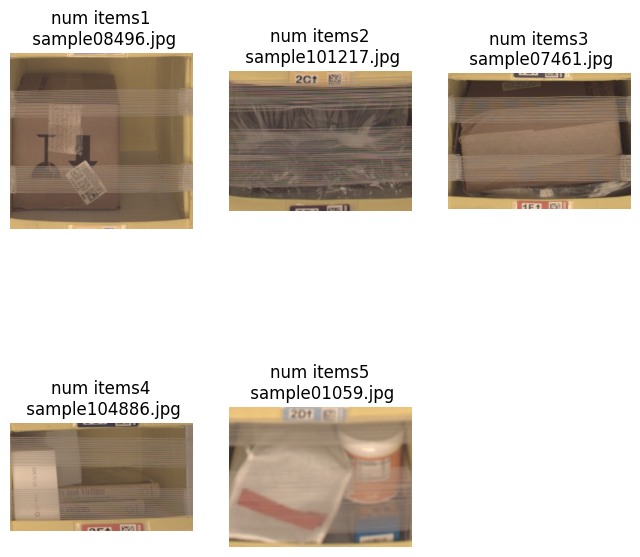

In [11]:
# Data visualzation
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 2

for key in num_items.keys():
    sample_idx = random.randint(0, num_items[key]-1)
    img_filename = file_lists[key][sample_idx]
    label = "num items" +key + "\n sample" + img_filename
    figure.add_subplot(rows, cols, int(key))
    plt.title(label)
    plt.axis("off")
    plt.imshow(mpimg.imread(os.path.join(local_data_path, key, img_filename)).squeeze(), cmap="gray")
    
plt.show()
figure.savefig('sample_dataset_images.png')

In [12]:
# Dataset split into Train: 60%, Test: 20%, Valid: 20%
# Select files for each collection
file_list_train = {}
file_list_test = {}
file_list_valid = {}

for key in num_items.keys():
    valid_no = int(0.2*num_items[key])
    test_no = int(0.2*num_items[key])
    train_no =  int(num_items[key] - test_no - valid_no)
    file_list_valid[key] = []
    file_list_test[key] = []
    file_list_train[key] = []
    for idx, filename in enumerate(file_lists[key]):
        if idx < valid_no:
            file_list_valid[key].append(filename)
        elif (idx >= valid_no and idx<(test_no+valid_no)):
            file_list_test[key].append(filename)
        else:
            file_list_train[key].append(filename)
            
    print(f'num items {key}: Valid: {valid_no}, Test: {test_no}, Train: {train_no}')

num items 1: Valid: 245, Test: 245, Train: 738
num items 2: Valid: 459, Test: 459, Train: 1381
num items 3: Valid: 533, Test: 533, Train: 1600
num items 4: Valid: 474, Test: 474, Train: 1425
num items 5: Valid: 375, Test: 375, Train: 1125


In [13]:
import shutil

In [14]:
split_localdata_path = 'train_test_valid_split'

In [15]:
# 
try:
    os.mkdir(split_localdata_path)
    os.mkdir(os.path.join(split_localdata_path, 'valid'))
    os.mkdir(os.path.join(split_localdata_path, 'test'))
    os.mkdir(os.path.join(split_localdata_path, 'train'))
except OSError as error:
    print(error)   

for key in num_items.keys():
    try:
        os.mkdir(os.path.join(split_localdata_path, 'valid', key))
        os.mkdir(os.path.join(split_localdata_path, 'test', key))
        os.mkdir(os.path.join(split_localdata_path, 'train', key))
    except OSError as error:
        print(error)
        
    for filename in file_list_valid[key]:
        shutil.copy(os.path.join(local_data_path, key, filename), os.path.join(split_localdata_path,'valid', key, filename))
    for filename in file_list_test[key]:
        shutil.copy(os.path.join(local_data_path, key, filename), os.path.join(split_localdata_path,'test', key, filename))
    for filename in file_list_train[key]:
        shutil.copy(os.path.join(local_data_path, key, filename), os.path.join(split_localdata_path,'train', key, filename))
                
print('Finished..')

Finished..


In [3]:
# General macros
session = sagemaker.Session()
print("Default Session: {}".format(session))
bucket= session.default_bucket()
print("Default Bucket : {}".format(bucket))
region = session.boto_region_name
print("AWS Region     : {}".format(region))
role = sagemaker.get_execution_role()
print("RoleArn        : {}".format(role))

Default Session: <sagemaker.session.Session object at 0x7ff03faa1dd0>
Default Bucket : sagemaker-us-east-1-933845045900
AWS Region     : us-east-1
RoleArn        : arn:aws:iam::933845045900:role/service-role/AmazonSageMaker-ExecutionRole-20230130T210045


In [16]:
#arn:aws:s3:::object-count-tracking-using-aws-sagemaker
#s3://object-count-tracking-using-aws-sagemaker/dataset/
bucket_path = "s3://object-count-tracking-using-aws-sagemaker/"
dataset_path = os.path.join(bucket_path, split_localdata_path)
print(f"S3 bucket path    : {bucket_path}")
print(f"Dataset path in S3: {dataset_path}")

S3 bucket path    : s3://object-count-tracking-using-aws-sagemaker/
Dataset path in S3: s3://object-count-tracking-using-aws-sagemaker/train_test_valid_split


In [17]:
os.environ["DATASET_PATH"] = dataset_path
os.environ["DATASET_ORIGIN_PATH"] = split_localdata_path

In [19]:
# Upload the data to AWS S3 using sync
# https://awscli.amazonaws.com/v2/documentation/api/latest/reference/s3/sync.html
!aws s3 sync ${DATASET_ORIGIN_PATH} ${DATASET_PATH} --only-show-errors

## Model Training
**TODO:** This is the part where you can train a model. The type or architecture of the model you use is not important. 

**Note:** You will need to use the `train.py` script to train your model.

In [ ]:
#TODO: Declare your model training hyperparameter.
#NOTE: You do not need to do hyperparameter tuning. You can use fixed hyperparameter values

In [ ]:
#TODO: Create your training estimator

In [ ]:
# TODO: Fit your estimator

## Standout Suggestions
You do not need to perform the tasks below to finish your project. However, you can attempt these tasks to turn your project into a more advanced portfolio piece.

### Hyperparameter Tuning
**TODO:** Here you can perform hyperparameter tuning to increase the performance of your model. You are encouraged to 
- tune as many hyperparameters as you can to get the best performance from your model
- explain why you chose to tune those particular hyperparameters and the ranges.


In [ ]:
#TODO: Create your hyperparameter search space

In [ ]:
#TODO: Create your training estimator

In [ ]:
# TODO: Fit your estimator

In [ ]:
# TODO: Find the best hyperparameters

### Model Profiling and Debugging
**TODO:** Use model debugging and profiling to better monitor and debug your model training job.

In [ ]:
# TODO: Set up debugging and profiling rules and hooks

In [ ]:
# TODO: Create and fit an estimator

In [ ]:
# TODO: Plot a debugging output.

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [ ]:
# TODO: Display the profiler output

### Model Deploying and Querying
**TODO:** Can you deploy your model to an endpoint and then query that endpoint to get a result?

In [ ]:
# TODO: Deploy your model to an endpoint

In [ ]:
# TODO: Run an prediction on the endpoint

In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done

### Cheaper Training and Cost Analysis
**TODO:** Can you perform a cost analysis of your system and then use spot instances to lessen your model training cost?

In [ ]:
# TODO: Cost Analysis

In [ ]:
# TODO: Train your model using a spot instance

### Multi-Instance Training
**TODO:** Can you train your model on multiple instances?

In [ ]:
# TODO: Train your model on Multiple Instances